# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

%reload_ext tensorboard

## Procesamiento de datos

In [3]:

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'


In [6]:
covid19gt = pd.read_csv(url)

In [7]:
covid19gt.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,868,872,876,880,898,916,933,946,948,949
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,755,755,758,760,761,761,761,761,761,761
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,45,45,45,45,48,48,48,48,50,52


In [8]:
# Transformación de datos anchos a datos largos
covid19gt = covid19gt.drop(['Lat','Long'], axis = 1)

covid19gt = covid19gt.melt(id_vars=['Country/Region','Province/State'])


In [9]:
#Filtro para solo tomar en cuenta los datos de Guatemala
covid19gt = covid19gt[covid19gt['Country/Region'] == 'Guatemala']

covid19gt.tail()

,Country/Region,Province/State,variable,value
30447,Guatemala,NaN,5/15/20,1643
30713,Guatemala,NaN,5/16/20,1763
30979,Guatemala,NaN,5/17/20,1763
31245,Guatemala,NaN,5/18/20,1912
31511,Guatemala,NaN,5/19/20,2133


In [10]:
covid19gt.rename(columns = {'variable':'date', 'value':'confirmed'}, inplace = True)

In [11]:
covid19gt['date'] = pd.to_datetime(covid19gt['date'],infer_datetime_format = True)

In [12]:
# FIltración de datos para solo aquellos después de que Guatemala tuviera más de 0 casos
covid19gt = covid19gt[covid19gt['confirmed']>0]

In [13]:
# Generación de números para la fecha
covid19gt['datenum'] = np.linspace(start= 1, stop = len(covid19gt['date']), num = len(covid19gt['date']), dtype = int)

In [14]:
# Creación de feature con el logaritmo natural de la cantidad de casos confirmados
covid19gt['lnconfirmed'] = np.log(covid19gt['confirmed'])

## Exploración de datos

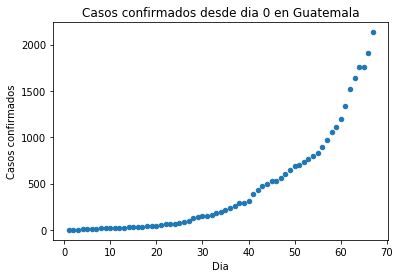

In [46]:
covid19gt.plot.scatter(x = 'datenum', y = 'confirmed')
plt.title('Casos confirmados desde dia 0 en Guatemala')
plt.xlabel("Dia")
plt.ylabel('Casos confirmados')

plt.show()

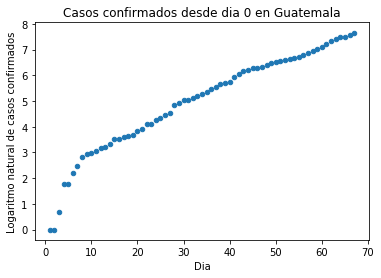

In [45]:

covid19gt.plot.scatter(x = 'datenum', y = 'lnconfirmed')
plt.title('Casos confirmados desde dia 0 en Guatemala')
plt.xlabel("Dia")
plt.ylabel('Logaritmo natural de casos confirmados')

plt.show()

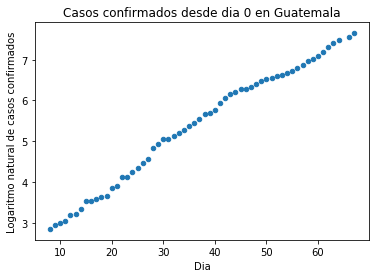

In [47]:
covid19gt_post22 = covid19gt[(covid19gt['datenum'] >= 8) & (covid19gt['datenum'] != 65)]

covid19gt_post22.plot.scatter(x = 'datenum', y = 'lnconfirmed')

plt.title('Casos confirmados desde dia 0 en Guatemala')
plt.xlabel("Dia")
plt.ylabel('Logaritmo natural de casos confirmados')


plt.show()

In [18]:
covid19gt_post22.head()

,Country/Region,Province/State,date,confirmed,datenum,lnconfirmed
15817,Guatemala,NaN,2020-03-21,17,8,2.833213
16083,Guatemala,NaN,2020-03-22,19,9,2.944439
16349,Guatemala,NaN,2020-03-23,20,10,2.995732
16615,Guatemala,NaN,2020-03-24,21,11,3.044522
16881,Guatemala,NaN,2020-03-25,24,12,3.178054


## Modelo de regresión lineal

In [48]:

# Modelo de regresión lineal con TF 

class LinearModel:
    def __init__ (self):
        # vector de weights, con 2 variables.
        self.w = tf.get_variable("weights", dtype = tf.float32, shape = [1,2], initializer = tf.zeros_initializer())
        
    # Funcion para generar prediccion de modelo
    def __call__(self, x):
        with tf.name_scope("model"):
            return tf.matmul(self.w,x)
    # Funcion de actualizacion de parametros por medio de gradient descent
    def update(self, x, y, learningrate):
        with tf.name_scope("error"):
            error = self.error(x,y)
            # Escalar de resumen
            error_summary = tf.summary.scalar("ErrorSummary", error)
        gradient = tf.gradients(error, [self.w])
        updated_w = tf.assign(self.w, self.w -learningrate * gradient[0])
        return updated_w, error, error_summary
    
    # Funcion para retornar MSE
    def error(self, x, y):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - self(x)))
        return error

In [49]:
y = covid19gt_post22["lnconfirmed"]
x = covid19gt_post22["datenum"]
x = np.array([x, np.ones_like(x)], dtype = "float64")

# Definicion para entrenamiento

def training(lr, epochs, frecprint):
    # String para definicion de experimento
    string = './graphs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs)

    g = tf.Graph()
    with g.as_default():
        # Inicialización de objeto de clase LinearModel
        modelo = LinearModel()
        # Definicion de placeholders para input de data a grafo
        tensor_x = tf.placeholder(tf.float32, [2,None], "tensor_x")
        tensor_y = tf.placeholder(tf.float32, [None], "tensor_y")
        # Utilizacion de método update para hacer el entrenamiento
        update_parameters = modelo.update(tensor_x, tensor_y, lr)
        
        # Writer para utilizacion de tensorboard
        writer = tf.summary.FileWriter(string, g)
        
        with tf.train.MonitoredSession() as session:
            feed_dict = {tensor_x:x, tensor_y:y}
            for i in range(epochs+1):
                
                # Entrenamiento
                training = session.run(update_parameters, feed_dict = feed_dict)
            
                if (i)%frecprint == 0:
                    # Cálculo de pesos para print por cada frecprint epocas
                    weights = session.run(modelo.w, feed_dict = feed_dict)
                    # Agregar datos a writer para poder visualizarlos en tensorboard
                    writer.add_summary(training[2], i)
                    print("Epoch: ", i, "Weights: ", weights, "Cost: ", training[1])
                    print("-------------------------------------------------------------------------")
                    
            return weights, training[1]

            writer.close()

### Entrenamiento por medio de *gradient descent* 

#### Experimentos para determinar número óptimo de épocas de entrenamiento y tasa de aprendizaje

In [22]:
training(0.1, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[22.334045   0.5376467]] Cost:  15.470852
-------------------------------------------------------------------------
Epoch:  10 Weights:  [[3.4080655e+23 7.5881691e+21]] Cost:  inf
-------------------------------------------------------------------------
Epoch:  20 Weights:  [[nan nan]] Cost:  nan
-------------------------------------------------------------------------
Epoch:  30 Weights:  [[nan nan]] Cost:  nan
-------------------------------------------------------------------------
Epoch:  40 Weights:  [[nan nan]] Cost:  nan
-------------------------------------------------------------------------
Epoch:  50 Weights:  [[nan nan]] Cost:  nan
-------------------------------------------------------------------------
Epoch:  60 Weights:  [[nan nan]] Cost:  nan
-------------------------------------------------------------------------
Epoch:  70 Weig

(array([[nan, nan]], dtype=float32), nan)

In [23]:
training(0.01, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[2.2334044  0.05376467]] Cost:  15.470852
-------------------------------------------------------------------------
Epoch:  10 Weights:  [[1.8419219e+12 4.1010991e+10]] Cost:  1.1543019e+25
-------------------------------------------------------------------------
Epoch:  20 Weights:  [[1.6161040e+24 3.5983085e+22]] Cost:  inf
-------------------------------------------------------------------------
Epoch:  30 Weights:  [[1.4179708e+36 3.1571581e+34]] Cost:  inf
-------------------------------------------------------------------------
Epoch:  40 Weights:  [[nan nan]] Cost:  nan
-------------------------------------------------------------------------
Epoch:  50 Weights:  [[nan nan]] Cost:  nan
-------------------------------------------------------------------------
Epoch:  60 Weights:  [[nan nan]] Cost:  nan
---------------------------------------

(array([[nan, nan]], dtype=float32), nan)

In [24]:
training(0.001, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[0.22334047 0.00537647]] Cost:  15.470852
-------------------------------------------------------------------------
Epoch:  10 Weights:  [[0.1355935  0.00745604]] Cost:  0.4792148
-------------------------------------------------------------------------
Epoch:  20 Weights:  [[0.13403691 0.01144761]] Cost:  0.4733958
-------------------------------------------------------------------------
Epoch:  30 Weights:  [[0.13392293 0.01546423]] Cost:  0.47177953
-------------------------------------------------------------------------
Epoch:  40 Weights:  [[0.13383324 0.01947436]] Cost:  0.47017014
-------------------------------------------------------------------------
Epoch:  50 Weights:  [[0.13374409 0.02347746]] Cost:  0.46856645
-------------------------------------------------------------------------
Epoch:  60 Weights:  [[0.13365512 0.02747354]] Cos

(array([[0.13330078, 0.04338796]], dtype=float32), 0.4606319)

In [25]:
training(0.001, 150, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[0.22334047 0.00537647]] Cost:  15.470852
-------------------------------------------------------------------------
Epoch:  10 Weights:  [[0.1355935  0.00745604]] Cost:  0.4792148
-------------------------------------------------------------------------
Epoch:  20 Weights:  [[0.13403691 0.01144761]] Cost:  0.4733958
-------------------------------------------------------------------------
Epoch:  30 Weights:  [[0.13392293 0.01546423]] Cost:  0.47177953
-------------------------------------------------------------------------
Epoch:  40 Weights:  [[0.13383324 0.01947436]] Cost:  0.47017014
-------------------------------------------------------------------------
Epoch:  50 Weights:  [[0.13374409 0.02347746]] Cost:  0.46856645
-------------------------------------------------------------------------
Epoch:  60 Weights:  [[0.13365512 0.02747354]] Cos

(array([[0.13286133, 0.06312455]], dtype=float32), 0.4528353)

In [50]:
%tensorboard --logdir ./graphs --port 6007

Reusing TensorBoard on port 6007 (pid 1072), started 0:13:39 ago. (Use '!kill 1072' to kill it.)

In [33]:
weights, error = training(0.001, 150, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[0.22334047 0.00537647]] Cost:  15.470852
-------------------------------------------------------------------------
Epoch:  10 Weights:  [[0.1355935  0.00745604]] Cost:  0.4792148
-------------------------------------------------------------------------
Epoch:  20 Weights:  [[0.13403691 0.01144761]] Cost:  0.4733958
-------------------------------------------------------------------------
Epoch:  30 Weights:  [[0.13392293 0.01546423]] Cost:  0.47177953
-------------------------------------------------------------------------
Epoch:  40 Weights:  [[0.13383324 0.01947436]] Cost:  0.47017014
-------------------------------------------------------------------------
Epoch:  50 Weights:  [[0.13374409 0.02347746]] Cost:  0.46856645
-------------------------------------------------------------------------
Epoch:  60 Weights:  [[0.13365512 0.02747354]] Cos

In [35]:
weights, error = training(0.001, 150000, 15000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Weights:  [[0.22334047 0.00537647]] Cost:  15.470852
-------------------------------------------------------------------------
Epoch:  15000 Weights:  [[0.0866705 2.1376884]] Cost:  0.014730908
-------------------------------------------------------------------------
Epoch:  30000 Weights:  [[0.08325113 2.2912624 ]] Cost:  0.012339079
-------------------------------------------------------------------------
Epoch:  45000 Weights:  [[0.08300443 2.3023424 ]] Cost:  0.012326671
-------------------------------------------------------------------------
Epoch:  60000 Weights:  [[0.08300085 2.3025024 ]] Cost:  0.012326649
-------------------------------------------------------------------------
Epoch:  75000 Weights:  [[0.08300085 2.3025024 ]] Cost:  0.012326649
-------------------------------------------------------------------------
Epoch:  90000 Weights:  [[0.08

In [36]:
prediction = weights[0][0] * covid19gt_post22['datenum'] + weights[0][1]

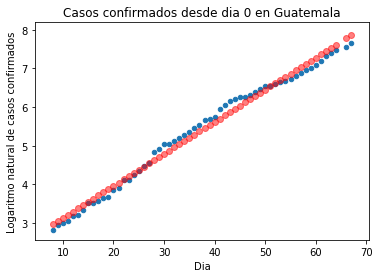

In [51]:


covid19gt_post22.plot.scatter(x = 'datenum', y = 'lnconfirmed')
plt.scatter(x = covid19gt_post22['datenum'], y = prediction, color = 'red', alpha = 0.5)
plt.title('Casos confirmados desde dia 0 en Guatemala')
plt.xlabel("Dia")
plt.ylabel('Logaritmo natural de casos confirmados')


plt.show()

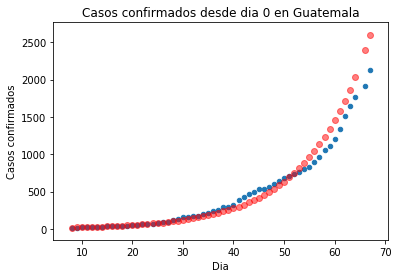

In [52]:

covid19gt_post22.plot.scatter(x = 'datenum', y = 'confirmed')
plt.scatter(x = covid19gt_post22['datenum'], y = np.exp(prediction), color = 'red', alpha = 0.5)
plt.title('Casos confirmados desde dia 0 en Guatemala')
plt.xlabel("Dia")
plt.ylabel('Casos confirmados')
plt.show()


In [39]:
prediction1 = weights[0][0] * np.linspace(1,78, 78) + weights[0][1]

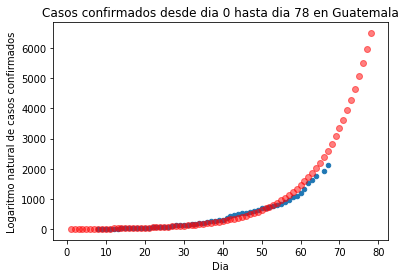

In [53]:
covid19gt_post22.plot.scatter(x = 'datenum', y = 'confirmed')
plt.scatter(x = np.linspace(1,78, 78), y = np.exp(prediction1), color = 'red', alpha = 0.5)
plt.title('Casos confirmados desde dia 0 hasta dia 78 en Guatemala')
plt.xlabel("Dia")
plt.ylabel('Logaritmo natural de casos confirmados')
plt.show()


In [54]:
#Predicción para el día 30 de mayo

np.exp(prediction1[-1])

6480.6038972551705

## Conclusiones Parte 1:

* El número de casos esperados para el día 78 de pandemia en Guatemala, o sea el 30 de mayo es de **6481**
* Por la transformación aplicada a la variable, el error también se ve exponenciado, por lo que aunque el error parezca pequeño en el entrenamiento, al momento de utilizar el modelo para generar una predicción se hace una sobreestimación del número de casos.


## Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [115]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
803,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,6
124,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,5
350,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,6
682,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,5
1326,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,6


In [59]:
# Importacion de librerias a utilizar 
import pandas as pd
import seaborn as sb

In [56]:
# Cargar data
data = pd.read_csv('winequality-red.csv')

In [57]:
#Split de datos de entrenamiento y test

#Random seed para reproducibilidad de los resultados

np.random.seed(42)

# Shuffle de datos
data = data.sample(frac=1)

#Training and test split
train = int(0.8 * len(data))

dftrain = data[:train]

dftest = data[:-train]

print('Longitud de set de entrenamiento: ',len(dftrain), ', Longitud de set de prueba: ', len(dftest))

Longitud de set de entrenamiento:  1279 , Longitud de set de prueba:  320


### Análisis exploratorio de datos

In [22]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


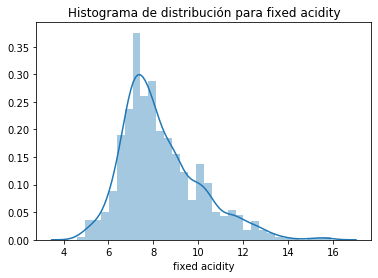

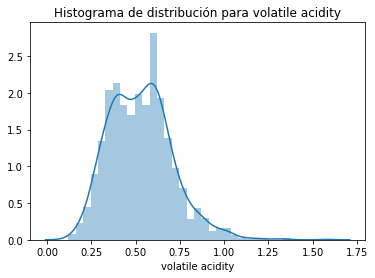

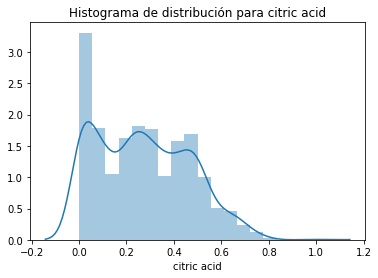

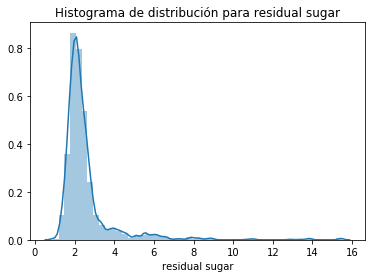

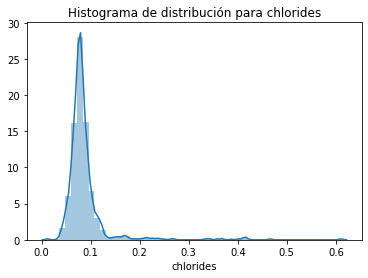

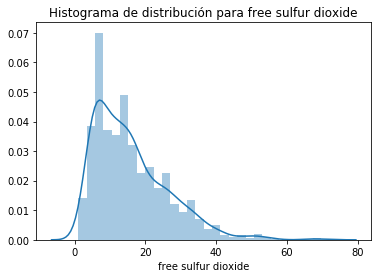

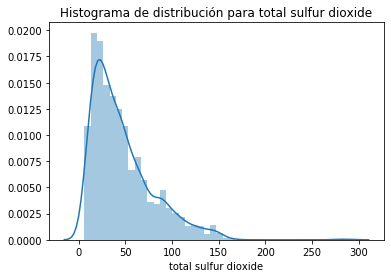

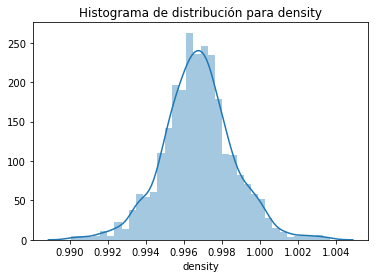

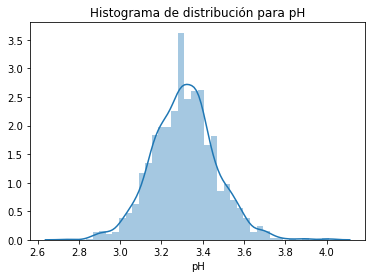

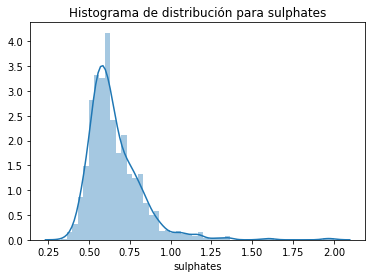

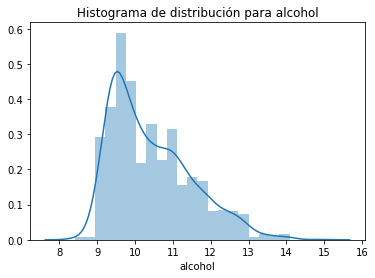

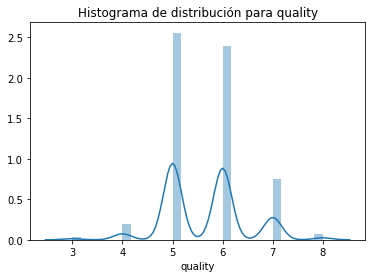

In [57]:
# Generación de histogramas para visualizar distribución de cada variable
for i in range(0,len(data.columns)):
    
    name = str(data.columns[i])
    
    plotname = "Histograma de distribución para " + name
    
    sb.distplot(data[data.columns[i]]).set_title(plotname)
    plt.show()
    

Al visualizar los histogramas para cada una de las variables del dataset podemos observar lo siguiente:

* La variable `quality` es numérica discreta, y su distribución, no obstante, asemeja la normalidad.
* La mayoría de variables independientes muestran una distribución normal, exceptuando `citric acid`, que muestra una distribución unimodal, pero con aspecto uniforme en muchas partes, y las variables `alcohol`, `free sulfur dioxide` y `total sulfur dioxide` muestran una distribución con sesgo hacia la derecha. 

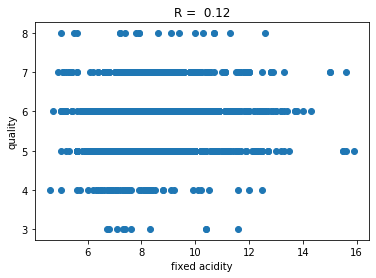

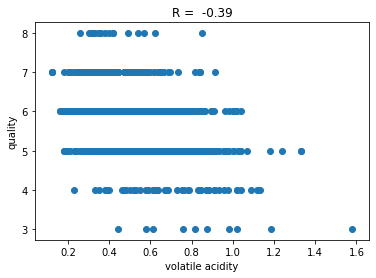

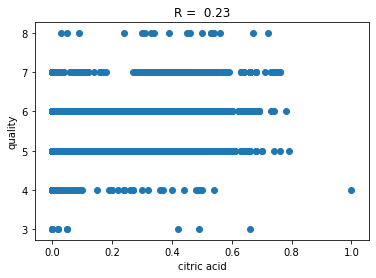

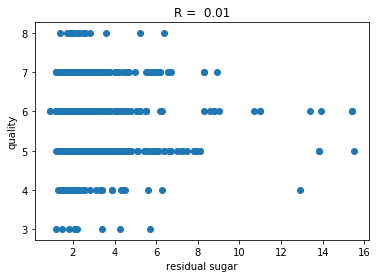

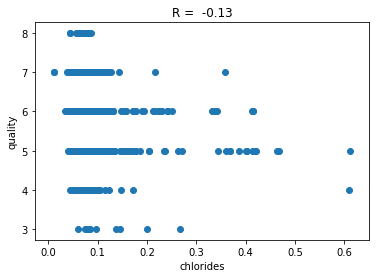

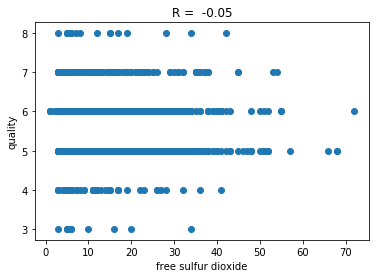

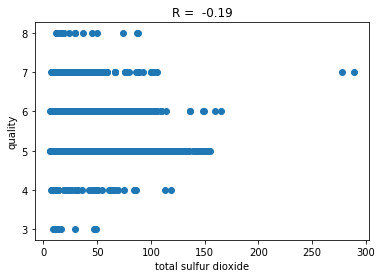

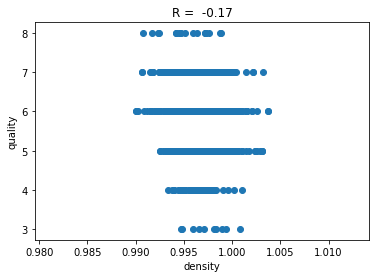

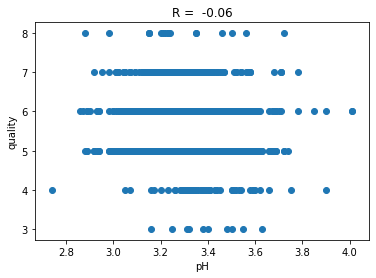

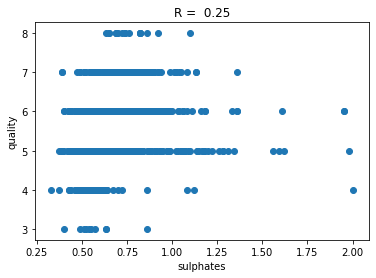

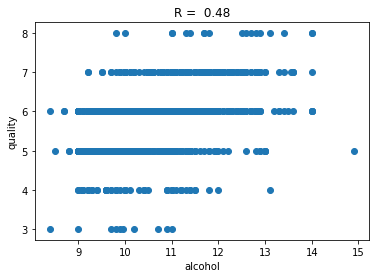

In [60]:
# Generación de scatter plots para visualizar variables independientes vs quality

for i in range(0, len(data.columns)-1):
    
    # Cálculo de la correlación para colocarla como título
    corr = round(data[data.columns[i]].corr(data['quality']),2)
    title = "R =  " + str(corr)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(data[data.columns[i]], data['quality'])
    ax.set_xlabel(data.columns[i])
    ax.set_ylabel(data.columns[-1])
    ax.set_title(title)
    plt.show()

Al observar los gráficos de dispersión se verifica que hay algunas variables que tienen coeficientes de correlación lineal mayores que otras, con algunas muy cercanas a uno, y por lo tanto probablemente despreciables.

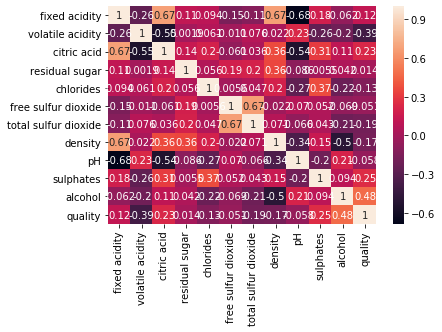

In [60]:
# Generación de matriz de correlación de dataset
corrMatrix = data.corr()

# Heatmap para visualizar matriz de correlación
sb.heatmap(corrMatrix, annot=True)
plt.show()

Tras la observación de esta primera matriz de correlación, la cual se encuentra muy sobrecargada, se decide descartar las variables que tienen coeficientes de correlación con respecto a `quality` muy cercanos a 0. 

In [61]:
# Se descartan variables con R cercanos a 0
df = data.drop(columns = ['residual sugar', 'free sulfur dioxide', 'pH'])

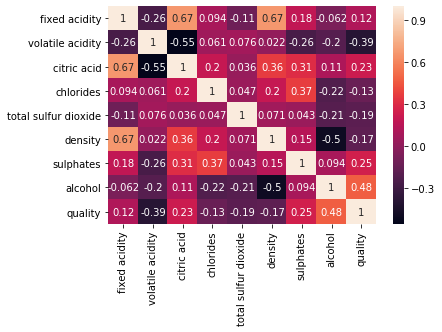

In [70]:
corrMatrix = df.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

En esta matriz de correlación se tiene una mejor visualización de los valores que toman los coeficientes de correlación. De este gráfico se observa cuales son las variables que poseen mayor coeficiente de correlación nuevamente, esta vez todas aquellas son un R mayor a 0.20 o menor a -0.20. 

In [62]:
# Se descartan variables con R mayor a 0.20 o menor a -0.20
df = df.drop(columns = ['chlorides', 'fixed acidity', 'total sulfur dioxide', 'density'])

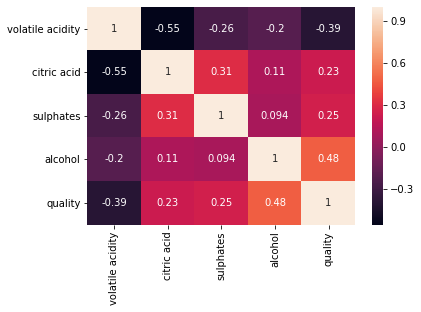

In [72]:
corrMatrix = df.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

Al tener ya las cuatro variables que muestran mayor correlación con la variable dependiente, se decide utilizar la matriz de correlación para buscar variables independientes que tengan alto coeficiente de correlación entre sí, para asi evitar la multicolinealidad en el modelo. Se observa que la variable `citric acid`, que tiene el menor $R$ de todas las variables, muestra también una alta correlación con la variable `volatile acidity`. Por esta razón se decide descartar `citric acid`. 

In [63]:
# Se descarta variable citric acid
df = df.drop(columns = ['citric acid'])

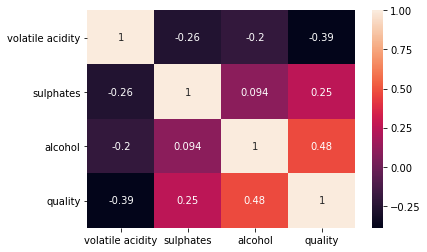

In [64]:
corrMatrix = df.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

### Distribución de variables escogidas para el modelo

Se hace un chequeo rápido de las distribuciones de las variables escogidas para el modelo en el set de entrenamiento.

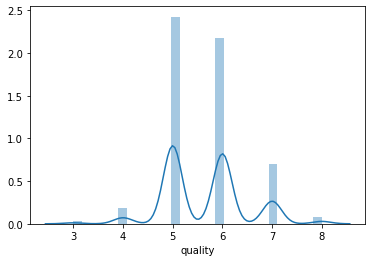

In [65]:
sb.distplot(dftrain['quality'])
plt.show()

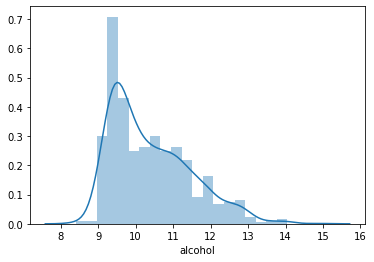

In [66]:

sb.distplot(dftrain['alcohol'])
plt.show()

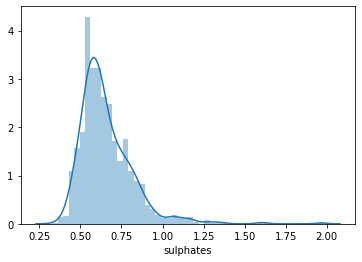

In [67]:
sb.distplot(dftrain['sulphates'])
plt.show()

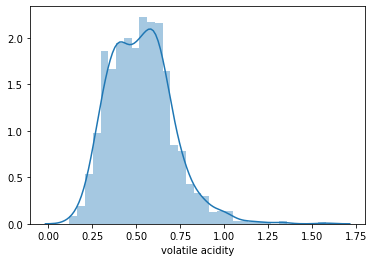

In [68]:
sb.distplot(dftrain['volatile acidity'])
plt.show()

Las 3 variables a utilizar para el modelo de regresión lineal serán:

* `sulphates`
* `volatile acidity`
* `alcohol`

### Modelo de regresión polinomial


Un modelo de regresión polimomial busca encontrar la combinación lineal que minimice el error cuadrado medio.

La ecuación:

$h(\mathbf{X}) = \mathbf{wX}+ b$

donde: 

* $\mathbf{x}$ : Matriz de variables independientes
* $\mathbf{w}$ : Vector con los pesos de los parametros
* $b$ : Bias o sesgo

En un modelo polinomial se generan las siguientes características para crear un modelo polinomial de $z$ grado:

* $\mathbf{x_j}^z$ donde $z$ va desde 1 hasta el grado de modelo polinomial que se desea.
* Términos de interacción $\binom{n}{k}$ de multiplicación de las características originales donde: 
    - $n$ es el numero de filas en la matriz de características
    - $k$ es un número que varia de 2 hasta el número de $n$ de filas.


Función de costo:

$C(\mathbf{w},b) = \frac{1}{2} \sum_{i=1}^{n} (y_i − h(\mathbf{x}_i))^2$

donde:

* $y_i$ : Valor real de cada dato en el dataset
* $h(\mathbf{x}_{i})$ : Valor predecido por el modelo

Para poder optimizar este modelo es necesario encontrar los valores de $w$ y $b$ que minimizan la función de costo.
Esto se realiza a través de un aprendizaje por medio de *gradient descent*.

### Entrenamiento de modelo de regresión polinomial mediante ***gradient descent***

El modelo de regresión lineal se entrenará utilizando la siguiente función de costo. El algoritmo de *gradient descent* calcula la derivada parcial para cada uno de los parámetros de la función de costo. En cada iteración se realiza una modificación pequeña proporcional a esas derivadas parciales calculadas. A continuación se presenta este concepto en notación matemática.


Función de costo:

$C(\mathbf{w},b) = \frac{1}{2m} \sum_{i=1}^{m} (y_{i} − h(\mathbf{x}_i))^2$

donde:

* $y_{i}$ : Valor real de cada dato en el dataset
* $h(\mathbf{x}_i)$ : Valor predecido por el modelo

Derivadas parciales:

$\frac{\partial \mathbf{w} }{\partial C} = \frac{1}{n} \sum_{i=1}^{n} (y_i − h(\mathbf{x}_i))*\mathbf{w}$

$\frac{\partial b }{\partial C} = \frac{1}{n} \sum_{i=1}^{n} (y_i − h(\mathbf{x}_i))$

*Gradient descent*:

$\mathbf{w} = \mathbf{w} - \alpha \frac{1}{n} \sum_{i=1}^{n} (y_i - h(\mathbf{x}_i))*\mathbf{w})$

$b = b - \alpha \frac{1}{n} \sum_{i=1}^{n} (y_i − h(\mathbf{x}_i))$

$\alpha$ = tasa de aprendizaje

Los valores de $\mathbf{w}$ y $b$ son actualizados iterativamente hasta minimizar el error, en otras palabras, hasta encontrar la línea de regresión que minimiza el error entre los datos predecidos y los datos reales.

In [73]:
# Definición de la clase PolynomialModel para posteriormente utilizarla para crear una funcion de entrenamiento
class PolynomialModel:
    def __init__(self, features):
        
        #vector de weights con n features
        self.w = tf.get_variable("weights", dtype = tf.float32, shape = [1, features], initializer = tf.zeros_initializer())
    
    # Funcion para generar prediccion de modelo    
    def __call__(self, x):
        with tf.name_scope("model"):
            return tf.matmul(self.w, x)
     
    # Funcion de actualizacion de parametros por medio de batch gradient descent
    def update(self, xtrain, ytrain, xtest, ytest, learningrate):
        with tf.name_scope("error"):
            train_error = self.error(xtrain, ytrain)
            train_error_summ = tf.summary.scalar("TrainError", train_error)
            test_error = self.error(xtest, ytest)
            test_error_summ = tf.summary.scalar("TestError", test_error)
        gradient = tf.gradients(train_error, [self.w])
        updated_w = tf.assign(self.w, self.w - learningrate * gradient[0])
        return updated_w, train_error, test_error, train_error_summ, test_error_summ
    
    # Funcion para retornar MSE
    def error(self, x, y):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - self(x)))
        return error
        

In [70]:
# Función de entrenamiento
def trainingPoly(features_train, ytrain, features_test, ytest, polydegree, lr, epochs, frecprint):
    
    #definicion de features
    from sklearn.preprocessing import PolynomialFeatures
    
    xtrain = PolynomialFeatures(polydegree).fit_transform(features_train)
    xtest = PolynomialFeatures(polydegree).fit_transform(features_test)

    #string para definición de experimento
    string = './graphsWhine/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs) + "_polydegree=" + str(polydegree)
    
    g = tf.Graph()
    
    num_features = xtrain.shape[1]
    num_rows = xtrain.shape[0]
    num_rowstest = xtest.shape[0]
    
    with g.as_default():
        #inicializacion de objeto de clase PolynomialModel
        model = PolynomialModel(num_features)
        # Definición de placeholders para input de data
        tensor_xtrain = tf.placeholder(tf.float32, [num_features, num_rows], "tensor_xtrain")
        tensor_ytrain = tf.placeholder(tf.float32, [num_rows], "tensor_ytrain")
        tensor_xtest = tf.placeholder(tf.float32, [num_features, num_rowstest], "tensor_xtest")
        tensor_ytest = tf.placeholder(tf.float32, [num_rowstest], "tensor_ytest")
        # Utilizacion de metodo update para hacer el entrenamiento
        update_parameters = model.update(tensor_xtrain, tensor_ytrain, tensor_xtest, tensor_ytest, lr)
        
        #Writer para utilizacion de tensorboard
        writer = tf.summary.FileWriter(string, g)
        
        with tf.train.MonitoredSession() as session:
            feed_dict = {tensor_xtrain:xtrain.T, tensor_ytrain:ytrain, tensor_xtest:xtest.T, tensor_ytest:ytest}
            
            for i in range(epochs + 1):
                
                #Entrenamiento
                training = session.run(update_parameters, feed_dict = feed_dict)
                
                if (i)%frecprint == 0:
                    # Calculo de pesos para print por cada frecprint epocas
                    weights = session.run(model.w, feed_dict = feed_dict)
                    # Agregar datos a writer para poder visualizarlos en tensorboard
                    writer.add_summary(training[3], i)
                    writer.add_summary(training[4], i)
                    print("Epoch: ", i, "Training Cost: ", training[1], "Test Cost: ", training[2])
                    print("--------------------------------------------------------")
                    
            return weights, training[1], training[2]
        
        writer.close()
    

In [74]:
# Definición de features y variables dependientes para el set de entrenamiento y el set de prueba
features_train = dftrain[['sulphates','volatile acidity', 'alcohol']]
features_test= dftest[['sulphates','volatile acidity', 'alcohol']]
ytrain = dftrain['quality']
ytest = dftest['quality']

In [75]:
trainingPoly(features_train, ytrain, features_test, ytest, 2, 0.1, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  10 Training Cost:  inf Test Cost:  inf
--------------------------------------------------------
Epoch:  20 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  30 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  40 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  50 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  60 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  70 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  80 Training Cost:  nan Test C

(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32),
 nan,
 nan)

In [76]:
trainingPoly(features_train, ytrain, features_test, ytest, 2, 0.01, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  10 Training Cost:  inf Test Cost:  inf
--------------------------------------------------------
Epoch:  20 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  30 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  40 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  50 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  60 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  70 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  80 Training Cost:  nan Test C

(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32),
 nan,
 nan)

In [77]:
trainingPoly(features_train, ytrain, features_test, ytest, 2, 0.0001, 1000, 100)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  100 Training Cost:  0.57032865 Test Cost:  0.57841307
--------------------------------------------------------
Epoch:  200 Training Cost:  0.55647177 Test Cost:  0.56343883
--------------------------------------------------------
Epoch:  300 Training Cost:  0.5434537 Test Cost:  0.5493387
--------------------------------------------------------
Epoch:  400 Training Cost:  0.5312145 Test Cost:  0.53605163
--------------------------------------------------------
Epoch:  500 Training Cost:  0.5196996 Test Cost:  0.5235211
--------------------------------------------------------
Epoch:  600 Training Cost:  0.50885755 Test Cost:  0.511695
--------------------------------------------------------
Epoch:  700 Training Cost:  0.49864137 Test Cost:  0.50052

(array([[0.01535553, 0.01089976, 0.00610752, 0.08465699, 0.00835616,
         0.00441001, 0.06424524, 0.00169982, 0.02521121, 0.03673137]],
       dtype=float32), 0.4713277, 0.4705224)

In [78]:
trainingPoly(features_train, ytrain, features_test, ytest, 2, 0.0001, 10000, 1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  1000 Training Cost:  0.4713277 Test Cost:  0.4705224
--------------------------------------------------------
Epoch:  2000 Training Cost:  0.40671757 Test Cost:  0.39854518
--------------------------------------------------------
Epoch:  3000 Training Cost:  0.36677882 Test Cost:  0.35317922
--------------------------------------------------------
Epoch:  4000 Training Cost:  0.3398971 Test Cost:  0.32230872
--------------------------------------------------------
Epoch:  5000 Training Cost:  0.32039154 Test Cost:  0.2998852
--------------------------------------------------------
Epoch:  6000 Training Cost:  0.30538237 Test Cost:  0.28275204
--------------------------------------------------------
Epoch:  7000 Training Cost:  0.29334316 Test Cost

(array([[ 0.08256022,  0.04002777,  0.01939961,  0.4460459 ,  0.00973667,
          0.00588634,  0.1571098 , -0.0075298 , -0.01270632, -0.00161345]],
       dtype=float32), 0.26803824, 0.24138208)

In [79]:
trainingPoly(features_train, ytrain, features_test, ytest, 2, 0.0001, 100000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  10000 Training Cost:  0.26803824 Test Cost:  0.24138208
--------------------------------------------------------
Epoch:  20000 Training Cost:  0.23472212 Test Cost:  0.20675392
--------------------------------------------------------
Epoch:  30000 Training Cost:  0.2272667 Test Cost:  0.19943705
--------------------------------------------------------
Epoch:  40000 Training Cost:  0.2255464 Test Cost:  0.19786526
--------------------------------------------------------
Epoch:  50000 Training Cost:  0.22510642 Test Cost:  0.19751818
--------------------------------------------------------
Epoch:  60000 Training Cost:  0.22495292 Test Cost:  0.1974206
--------------------------------------------------------
Epoch:  70000 Training Cost:  0.2248639 Te

(array([[ 0.13880843,  0.03986288,  0.02545932,  0.7500064 , -0.08316958,
         -0.01021907,  0.08921913, -0.02924899, -0.10833053, -0.02116229]],
       dtype=float32), 0.22465192, 0.19722179)

In [80]:
# Prueba con polinomio grado 1, o sea un modelo con las 3 variables y el sesgo unicamente
trainingPoly(features_train, ytrain, features_test, ytest, 1, 0.01, 100000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  10000 Training Cost:  0.23316988 Test Cost:  0.20535442
--------------------------------------------------------
Epoch:  20000 Training Cost:  0.22877012 Test Cost:  0.20031694
--------------------------------------------------------
Epoch:  30000 Training Cost:  0.22755429 Test Cost:  0.19906482
--------------------------------------------------------
Epoch:  40000 Training Cost:  0.22721358 Test Cost:  0.19872288
--------------------------------------------------------
Epoch:  50000 Training Cost:  0.22711809 Test Cost:  0.1986295
--------------------------------------------------------
Epoch:  60000 Training Cost:  0.22709134 Test Cost:  0.19860432
--------------------------------------------------------
Epoch:  70000 Training Cost:  0.2270839 

(array([[ 2.6609354 ,  0.7512496 , -1.1691446 ,  0.29787695]],
       dtype=float32), 0.22708099, 0.19859539)

In [81]:
trainingPoly(features_train, ytrain, features_test, ytest, 3, 0.0001, 10000, 1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  1000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  2000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  3000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  4000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  5000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  6000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  7000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  8000 Training C

(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]], dtype=float32), nan, nan)

In [82]:
trainingPoly(features_train, ytrain, features_test, ytest, 3, 0.00001, 10000, 1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  1000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  2000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  3000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  4000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  5000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  6000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  7000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------
Epoch:  8000 Training C

(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]], dtype=float32), nan, nan)

In [83]:
trainingPoly(features_train, ytrain, features_test, ytest, 3, 0.000001, 10000, 1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  1000 Training Cost:  0.8701024 Test Cost:  0.90067595
--------------------------------------------------------
Epoch:  2000 Training Cost:  0.67563826 Test Cost:  0.68857735
--------------------------------------------------------
Epoch:  3000 Training Cost:  0.56590337 Test Cost:  0.56687266
--------------------------------------------------------
Epoch:  4000 Training Cost:  0.49544325 Test Cost:  0.48809513
--------------------------------------------------------
Epoch:  5000 Training Cost:  0.4453849 Test Cost:  0.43221277
--------------------------------------------------------
Epoch:  6000 Training Cost:  0.40729865 Test Cost:  0.3900515
--------------------------------------------------------
Epoch:  7000 Training Cost:  0.37707248 Test Cos

(array([[ 1.9283608e-03,  9.8307210e-04,  6.7652797e-04,  1.3836916e-02,
          3.8614869e-04,  3.0281668e-04,  6.2363734e-03,  1.3184139e-04,
          3.7628340e-03,  7.5038873e-02, -6.7040870e-05,  5.8544992e-05,
          1.4085630e-03,  2.9757055e-05,  1.1068825e-03,  2.0005720e-02,
         -1.5411321e-04, -5.3740834e-04,  3.0592645e-03, -3.8706863e-03]],
       dtype=float32), 0.31534442, 0.29107103)

In [84]:
trainingPoly(features_train, ytrain, features_test, ytest, 3, 0.000001, 200000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  10000 Training Cost:  0.31534442 Test Cost:  0.29107103
--------------------------------------------------------
Epoch:  20000 Training Cost:  0.24309716 Test Cost:  0.2179307
--------------------------------------------------------
Epoch:  30000 Training Cost:  0.23047426 Test Cost:  0.20640223
--------------------------------------------------------
Epoch:  40000 Training Cost:  0.22821838 Test Cost:  0.20477848
--------------------------------------------------------
Epoch:  50000 Training Cost:  0.22777174 Test Cost:  0.20463137
--------------------------------------------------------
Epoch:  60000 Training Cost:  0.22764124 Test Cost:  0.20463952
--------------------------------------------------------
Epoch:  70000 Training Cost:  0.22756681

(array([[ 3.5219362e-03,  1.2423089e-03,  1.2098219e-03,  2.3224903e-02,
         -1.2154160e-03,  2.6379531e-04,  6.4763385e-03, -7.3768453e-05,
          5.3648753e-03,  1.1438790e-01, -4.2414158e-03, -8.7811152e-04,
         -1.4477517e-02, -1.8869199e-04, -3.5756713e-04,  9.9962205e-03,
         -1.0497631e-03, -5.2632703e-03, -9.8490529e-03, -6.2522409e-03]],
       dtype=float32), 0.22682461, 0.20410228)

In [85]:
trainingPoly(features_train, ytrain, features_test, ytest, 4, 0.00000001, 100000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  10000 Training Cost:  0.3680621 Test Cost:  0.34756896
--------------------------------------------------------
Epoch:  20000 Training Cost:  0.2694541 Test Cost:  0.2504128
--------------------------------------------------------
Epoch:  30000 Training Cost:  0.25730485 Test Cost:  0.2409298
--------------------------------------------------------
Epoch:  40000 Training Cost:  0.25575396 Test Cost:  0.24053764
--------------------------------------------------------
Epoch:  50000 Training Cost:  0.2555047 Test Cost:  0.24072571
--------------------------------------------------------
Epoch:  60000 Training Cost:  0.25541562 Test Cost:  0.24079907
--------------------------------------------------------
Epoch:  70000 Training Cost:  0.2553469 Test

(array([[ 6.1782412e-05,  2.9084009e-05,  2.5773046e-05,  4.5417729e-04,
          5.5680812e-06,  1.1444189e-05,  1.9210055e-04,  7.3521219e-06,
          1.6691072e-04,  2.9577457e-03, -1.5860232e-05,  6.7752165e-07,
         -5.0309945e-06,  2.9119908e-06,  6.1806903e-05,  9.7563595e-04,
         -4.0685891e-06,  1.4646165e-05,  7.7617011e-04,  1.4308547e-02,
         -4.2059750e-05, -9.4728839e-06, -1.9551026e-04, -1.2750805e-06,
         -2.3880088e-05, -6.2272412e-04, -2.1867600e-06, -3.5666942e-06,
          1.1167297e-04,  8.5670268e-04, -1.3145078e-05, -8.5110310e-05,
         -4.3607983e-04, -8.9379132e-04, -9.2318165e-04]], dtype=float32),
 0.25515142,
 0.24063906)

In [86]:
trainingPoly(features_train, ytrain, features_test, ytest, 10, 0.0000000000000000000001, 1000000, 100000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------


KeyboardInterrupt: 

In [87]:
trainingPoly(features_train, ytrain, features_test, ytest, 10, 0.000000000000000000001, 100000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  10000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------


KeyboardInterrupt: 

In [88]:
trainingPoly(features_train, ytrain, features_test, ytest, 5, 0.0000000001, 100000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  10000 Training Cost:  nan Test Cost:  nan
--------------------------------------------------------


KeyboardInterrupt: 

In [89]:
trainingPoly(features_train, ytrain, features_test, ytest, 5, 0.00000000001, 10000, 1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  1000 Training Cost:  3.317849 Test Cost:  3.467628
--------------------------------------------------------
Epoch:  2000 Training Cost:  3.08153 Test Cost:  3.2256477
--------------------------------------------------------
Epoch:  3000 Training Cost:  2.8727772 Test Cost:  3.0113425
--------------------------------------------------------
Epoch:  4000 Training Cost:  2.687856 Test Cost:  2.8209858
--------------------------------------------------------
Epoch:  5000 Training Cost:  2.523571 Test Cost:  2.6513877
--------------------------------------------------------
Epoch:  6000 Training Cost:  2.3771815 Test Cost:  2.4998107
--------------------------------------------------------
Epoch:  7000 Training Cost:  2.2463362 Test Cost:  2.3639083
--

(array([[ 1.08402354e-07,  6.91850559e-08,  5.58643407e-08,
          9.39150198e-07,  4.74692747e-08,  3.49853622e-08,
          5.94871608e-07,  3.06908845e-08,  4.82827204e-07,
          7.69670896e-06,  3.60372674e-08,  2.34939606e-08,
          4.06399920e-07,  1.90650340e-08,  3.00080501e-07,
          4.80204653e-06,  1.73299011e-08,  2.62853803e-07,
          3.95466668e-06,  5.65830414e-05,  3.12355795e-08,
          1.74890502e-08,  3.09588756e-07,  1.26687967e-08,
          2.00431899e-07,  3.25046744e-06,  1.08257998e-08,
          1.62401591e-07,  2.42141209e-06,  3.40796541e-05,
          9.44699874e-09,  1.44781239e-07,  2.12807936e-06,
          2.92075983e-05,  3.14640754e-04,  3.15714495e-08,
          1.49840211e-08,  2.72220092e-07,  9.33598887e-09,
          1.49510925e-07,  2.48976471e-06,  7.20825488e-09,
          1.07479252e-07,  1.59965714e-06,  2.25378280e-05,
          6.11051876e-09,  9.04759432e-08,  1.30013791e-06,
          1.72848759e-05,  1.67196209e-0

In [90]:
trainingPoly(features_train, ytrain, features_test, ytest, 5, 0.00000000001, 100000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  16.482813
--------------------------------------------------------
Epoch:  10000 Training Cost:  1.9282687 Test Cost:  2.0314553
--------------------------------------------------------
Epoch:  20000 Training Cost:  1.3300962 Test Cost:  1.3936602
--------------------------------------------------------
Epoch:  30000 Training Cost:  1.0361216 Test Cost:  1.0713851
--------------------------------------------------------
Epoch:  40000 Training Cost:  0.8559118 Test Cost:  0.8717597
--------------------------------------------------------
Epoch:  50000 Training Cost:  0.7313936 Test Cost:  0.7343515
--------------------------------------------------------
Epoch:  60000 Training Cost:  0.640292 Test Cost:  0.6349428
--------------------------------------------------------
Epoch:  70000 Training Cost:  0.57182384 Test Cost: 

(array([[ 4.70932804e-07,  2.60998945e-07,  2.03080418e-07,
          4.00610861e-06,  1.37446605e-07,  1.08237153e-07,
          2.13196790e-06,  8.36724610e-08,  1.62207402e-06,
          3.22057676e-05,  5.62530005e-08,  5.23922026e-08,
          1.03583614e-06,  4.30284146e-08,  8.13717122e-07,
          1.59024385e-05,  2.21193481e-08,  5.75496358e-07,
          1.16654310e-05,  2.32031263e-04, -1.11242215e-08,
          1.54122688e-08,  3.14053608e-07,  1.85204030e-08,
          3.39359445e-07,  6.46638318e-06,  1.09148033e-08,
          2.64081223e-07,  5.10184327e-06,  9.60272082e-05,
         -1.62243676e-08,  3.50842448e-08,  2.85065198e-06,
          6.47226043e-05,  1.26230321e-03, -8.95863934e-08,
         -1.59935283e-08, -2.97585927e-07,  1.81487547e-09,
          2.24406520e-08,  2.47138701e-07,  2.89253643e-09,
          7.44303179e-08,  1.28077204e-06,  1.88254926e-05,
         -8.04723932e-09, -4.92816321e-09,  7.72249564e-07,
          1.59747942e-05,  2.10154467e-0

In [95]:
%tensorboard --logdir ./graphsWhine --port 6008

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 4016.

In [96]:
%tensorboard --logdir ./graphsWhine --port 6008

Reusing TensorBoard on port 6008 (pid 15884), started 0:01:27 ago. (Use '!kill 15884' to kill it.)

### Grafo de modelo de regresion polinomial

<img src="graphWhine.png">

### Resultados de experimentos de entrenamiento

#### Errores de test set tras completar entrenamiento
<img src="training.png">

#### Visualización logarítmica de errores de test set tras completar entrenamiento
<img src="logtraining.png">


### Pruebas adicionales utilizando diferente numero de features

In [97]:
# Definición de features y variables dependientes para el set de entrenamiento y el set de prueba
features_train2 = dftrain[['sulphates','volatile acidity', 'alcohol', 'citric acid']]
features_test2= dftest[['sulphates','volatile acidity', 'alcohol', 'citric acid']]
ytrain2 = dftrain['quality']
ytest2 = dftest['quality']

In [98]:
trainingPoly(features_train2, ytrain2, features_test2, ytest2, 2, 0.0001, 100000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  1.7540581
--------------------------------------------------------
Epoch:  10000 Training Cost:  0.269615 Test Cost:  0.24596047
--------------------------------------------------------
Epoch:  20000 Training Cost:  0.23671675 Test Cost:  0.2105594
--------------------------------------------------------
Epoch:  30000 Training Cost:  0.2281373 Test Cost:  0.2011486
--------------------------------------------------------
Epoch:  40000 Training Cost:  0.22585191 Test Cost:  0.19853981
--------------------------------------------------------
Epoch:  50000 Training Cost:  0.22520301 Test Cost:  0.19776057
--------------------------------------------------------
Epoch:  60000 Training Cost:  0.22498015 Test Cost:  0.19748719
--------------------------------------------------------
Epoch:  70000 Training Cost:  0.22486871 Tes

(array([[ 1.38895884e-01,  3.99480462e-02,  2.52421573e-02,
          7.49960184e-01,  1.40201598e-02, -8.22936594e-02,
         -9.96958558e-03,  8.98072943e-02, -1.32484902e-02,
         -3.23633626e-02, -1.08545735e-01, -1.90076578e-04,
         -2.11461857e-02, -1.74989970e-03, -4.75885347e-04]], dtype=float32),
 0.22464299,
 0.19716246)

In [99]:
# Definición de features y variables dependientes para el set de entrenamiento y el set de prueba
features_train3 = dftrain[['volatile acidity', 'alcohol']]
features_test3= dftest[['volatile acidity', 'alcohol']]
ytrain3 = dftrain['quality']
ytest3 = dftest['quality']

In [100]:
trainingPoly(features_train3, ytrain3, features_test3, ytest3, 2, 0.0001, 100000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Training Cost:  16.211884 Test Cost:  1.7099041
--------------------------------------------------------
Epoch:  10000 Training Cost:  0.28168258 Test Cost:  0.26615614
--------------------------------------------------------
Epoch:  20000 Training Cost:  0.24077731 Test Cost:  0.21880774
--------------------------------------------------------
Epoch:  30000 Training Cost:  0.2345722 Test Cost:  0.21098343
--------------------------------------------------------
Epoch:  40000 Training Cost:  0.23363043 Test Cost:  0.20955034
--------------------------------------------------------
Epoch:  50000 Training Cost:  0.23348702 Test Cost:  0.20923677
--------------------------------------------------------
Epoch:  60000 Training Cost:  0.23346463 Test Cost:  0.2091515
--------------------------------------------------------
Epoch:  70000 Training Cost:  0.23346074 

(array([[ 0.14916225,  0.02520874,  0.8065658 , -0.03211036, -0.1274016 ,
         -0.02022593]], dtype=float32), 0.23345819, 0.20910788)

# Conclusión Parte 2

* Se crearon varios modelos de regresión polinomial con 3 variables (`sulphates`, `volatile acidity`,`alcohol`) independientes y `quality` como variable dependiente.
* El modelo que generó mejores resultados fue un **modelo polinomial grado 2** tras **100000** épocas de entrenamiento y un learning rate de **0.0001** con un **MSE final de 0.1972.**, y un **RMSE de 0.444**. Por lo que se puede decir que en promedio nuestro error cometerá un error de 0.444 puntos al clasificar la calidad de cualquier vino.
* Un modelo con 4 variables independientes (`sulphates`, `volatile acidity`,`alcohol`, `citric acid`) puede generar un **MSE** levemente menor que el modelo con 3 variables tras la misma cantidad de entrenamiento, con un **MSE final de 0.1971**. Sin embargo se prefiere el modelo 3 variables por ser más simple. 